# Running model training on Azure ML Compute Clusters

In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
import matplotlib

In [3]:
%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
import prd_pipeline

## set up azure experiment


In [6]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Environment
from azureml.core import Experiment, ComputeTarget, ScriptRunConfig

In [7]:
prd_ws = Workspace.from_config()

In [8]:
use_full_dataset = False
if use_full_dataset:
    azure_dataset_name ='prd_merged_all_events_files'
else:
    #  use subset for development.
    azure_dataset_name ='prd_merged_202110_nswws_amber_oct_files'

In [74]:
azure_experiment_name='prd_mlops_test'

In [73]:
do_download_data = True # if false, use the azml dataset, otherwise download from datastore or blob store
use_blob_store = True # only applies if do download is true. If this is true, download from the blob store rather than the datastore.

In [75]:
if do_download_data and use_blob_store:
    # need to use th environment with fsspec if these flags are true
    azure_env_name = 'prd_ml_gpu_cluster'
else:
    azure_env_name = 'prd_ml_cluster'

In [83]:
use_gpu = True
if use_gpu:
    cluster_name = 'mlops-gpu-test'
else:
    cluster_name = 'mlops-test'
cluster_name

'mlops-gpu-test'

In [79]:
prd_model_name = 'azml_cluster_demo_mean_rain'

In [12]:
target_parameter = 'radar_mean_rain_instant'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [13]:
prd_exp = Experiment(workspace=prd_ws, name=azure_experiment_name)
prd_exp

Name,Workspace,Report Page,Docs Page
prd_mlops_test,precip_rediagnosis,Link to Azure Machine Learning studio,Link to Documentation


Get the AzML environment (basically a conda environment) from the workspace.

In [77]:
prd_env = Environment.get(workspace=prd_ws, name=azure_env_name)
prd_env

{
    "assetId": "azureml://locations/uksouth/workspaces/57546dc9-9763-4025-831d-c19991c81540/environments/prd_ml_gpu_cluster/versions/1",
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.2-cudnn8-ubuntu18.04",
        "baseImageRegistry": null,
        "buildContext": null,
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {},
    "inferencingStackVersion": null,
    "name": "prd_ml_gpu_cluster",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "conda-forge"
            ],
            "depen

### Load data

load the data from the script so we'renot duplicating code

In [41]:
import importlib 
importlib.reload(prd_pipeline)

<module 'prd_pipeline' from '/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/model_pipeline/prd_pipeline.py'>

In [45]:
import json

In [46]:
with open('credentials_file.json') as credentials_file:
    az_blob_cred = json.load(credentials_file)
    
az_blob_cred.keys()

dict_keys(['storage_acc_name', 'storage_acc_key', 'container'])

In [47]:
prd_blob_rel_path = 'prd/202008_storm_francis/prd_merged*csv'

In [48]:
%%time
input_data = prd_pipeline.load_data_azure_blob(
    az_blob_cred=az_blob_cred,
    blob_path=prd_blob_rel_path,
)


CPU times: user 17.6 s, sys: 2.81 s, total: 20.5 s
Wall time: 32.7 s


In [49]:
%%time
data_splits, data_dims = prd_pipeline.preprocess_data(
    input_data,
    feature_dict={'profile': profile_features, 'single_level': single_lvl_features,'target': target_parameter,},
    test_fraction=0.2, 
)

target has dims: 23
dropping zeros
getting profile columns
['relative_humidity_5.0', 'relative_humidity_10.0', 'relative_humidity_20.0', 'relative_humidity_30.0', 'relative_humidity_50.0', 'relative_humidity_75.0', 'relative_humidity_100.0', 'relative_humidity_150.0', 'relative_humidity_200.0', 'relative_humidity_250.0', 'relative_humidity_300.0', 'relative_humidity_400.0', 'relative_humidity_500.0', 'relative_humidity_600.0', 'relative_humidity_700.0', 'relative_humidity_800.0', 'relative_humidity_1000.0', 'relative_humidity_1250.0', 'relative_humidity_1500.0', 'relative_humidity_1750.0', 'relative_humidity_2000.0', 'relative_humidity_2250.0', 'relative_humidity_2500.0', 'relative_humidity_2750.0', 'relative_humidity_3000.0', 'relative_humidity_3250.0', 'relative_humidity_3500.0', 'relative_humidity_3750.0', 'relative_humidity_4000.0', 'relative_humidity_4500.0', 'relative_humidity_5000.0', 'relative_humidity_5500.0', 'relative_humidity_6000.0', 'air_temperature_5.0', 'air_temperature

In [18]:
# these are example calls to the code for easier debugging than running on a separate cluster
# model = prd_cluster_train_demo.build_model(**data_dims)
# model = prd_cluster_train_demo.train_model(model, data_splits)

In [19]:
# import datetime
# log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = './logs'

### Execute our training run on a cluster

In [84]:
prd_demo_compute_target = ComputeTarget(workspace=prd_ws, name=cluster_name)
prd_demo_compute_target

AmlCompute(workspace=Workspace.create(name='precip_rediagnosis', subscription_id='07efdc52-cd27-48ed-9443-3aad2b6b777b', resource_group='precip_rediagnosis'), name=mlops-gpu-test, id=/subscriptions/07efdc52-cd27-48ed-9443-3aad2b6b777b/resourceGroups/precip_rediagnosis/providers/Microsoft.MachineLearningServices/workspaces/precip_rediagnosis/computes/mlops-gpu-test, type=AmlCompute, provisioning_state=Succeeded, location=uksouth, tags={})

In [69]:
prd_demo_args = ['--dataset-name', azure_dataset_name,
                 '--target-parameter', target_parameter,
                 '--model-name', prd_model_name,
                ]

prd_demo_args += ['--profile-features']
prd_demo_args += profile_features
prd_demo_args += ['--single-level_features']
prd_demo_args += single_lvl_features
prd_demo_args += ['--epochs', 10]
prd_demo_args += ['--batch-size', 128]
prd_demo_args += ['--learning-rate', 0.01]
prd_demo_args += ['--test-fraction', 0.2]
prd_demo_args += ['--log-dir', log_dir]


In [71]:
if do_download_data:
    if use_blob_store:
        prd_demo_args += ['--data-path', prd_blob_rel_path]
        prd_demo_args += ['--blob']    
    else:
        prd_demo_args += ['--data-path', azureml.core.Dataset.get_by_name(prd_ws, azure_dataset_name).as_download()]

In [72]:
prd_demo_args

['--dataset-name',
 'prd_merged_202110_nswws_amber_oct_files',
 '--target-parameter',
 'radar_mean_rain_instant',
 '--model-name',
 'azml_cluster_demo_20220414',
 '--profile-features',
 'air_temperature',
 'relative_humidity',
 '--single-level_features',
 'air_pressure_at_sea_level',
 '--epochs',
 10,
 '--batch-size',
 128,
 '--learning-rate',
 0.01,
 '--test-fraction',
 0.2,
 '--log-dir',
 './logs',
 '--data-path',
 'prd/202008_storm_francis/prd_merged*csv',
 '--blob']

In [85]:
prd_run_src = ScriptRunConfig(source_directory=os.getcwd(),
                      script='prd_cluster_train_demo.py',
                      arguments=prd_demo_args,
                      compute_target=prd_demo_compute_target,
                      environment=prd_env)

In [86]:
prd_run = prd_exp.submit(prd_run_src)
prd_run

Experiment,Id,Type,Status,Details Page,Docs Page
prd_mlops_test,prd_mlops_test_1664552817_03c5efe4,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [27]:
from azureml.tensorboard import Tensorboard

In [28]:
tb = Tensorboard([prd_run])

In [29]:
# If successful, start() returns a string with the URI of the instance.
tb.start()

https://prd-ml-pipeline-6006.uksouth.instances.azureml.ms


'https://prd-ml-pipeline-6006.uksouth.instances.azureml.ms'

In [30]:
prd_run.wait_for_completion()
assert(prd_run.get_status() == "Completed")

In [31]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

## Evaluation

We now get the trained model to do some evaluatiion and create some plots

In [32]:
import tempfile

In [33]:
import tensorflow.keras

We download the model file into a temproary directory (so as not to pollute the local workspace) and load into memory to do inference

In [34]:
with tempfile.TemporaryDirectory() as td1:
    td_path = pathlib.Path(td1)
    prd_run.download_files(prefix=prd_model_name, output_directory=td1)
    model_path = td_path / prd_model_name
    list(model_path.iterdir())
    trained_model = tensorflow.keras.models.load_model(model_path)

2022-09-29 18:59:22.790195: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
trained_model

In [36]:
data_splits.keys()

dict_keys(['X_train', 'X_val', 'y_train', 'y_val'])

In [37]:
y_pred = trained_model.predict(data_splits['X_val'])

Text(0, 0.5, 'Predicted 3hr precip_accumulation value')

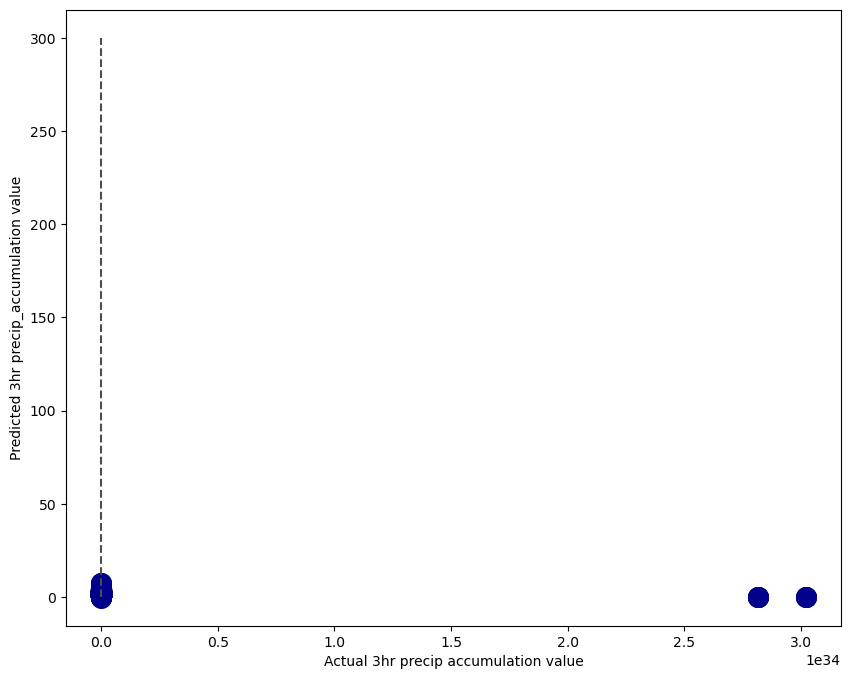

In [38]:
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(data_splits['y_val'], y_pred, s=200, c='darkblue')
ax1.plot([0, 300], [0, 300], ls="--", c=".3")
ax1.set_xlabel('Actual 3hr precip accumulation value')
ax1.set_ylabel('Predicted 3hr precip_accumulation value')

In [39]:
prd_run.log_image(name='actual_vs_pred', plot=fig1, description='predicted vs actual 3hr accumulations of rainfall')

In [40]:
prd_run.complete()